# Customer Cuhrn Data Analysis

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')

In [2]:
user = 'root'
password = '7003890541'
host = 'localhost'
port = '3306'
database = 'churn_final_project'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

In [3]:
def sql(query,engine = engine):
    return pd.read_sql(query,engine)

In [4]:
query = '''
        select * from data limit 5
    '''
sql(query)

,id,age,gender,tenure,frequency,calls,payment_delay,subscription,contract,spend,last_interaction,churn
0,2.0,30.0,female,39.0,14.0,5.0,18.0,standard,annual,932.0,17.0,1.0
1,3.0,65.0,female,49.0,1.0,10.0,8.0,basic,monthly,557.0,6.0,1.0
2,4.0,55.0,female,14.0,4.0,6.0,18.0,basic,quarterly,185.0,3.0,1.0
3,5.0,58.0,male,38.0,21.0,7.0,7.0,standard,monthly,396.0,29.0,1.0
4,6.0,23.0,male,32.0,20.0,5.0,8.0,basic,monthly,617.0,20.0,1.0


In [ ]:
num_cols = ['age','tenure','frequency','payment_delay','spend','last_interaction']
cat_cols = ['gender','subscription','calls','contract','churn']
all_cols = num_cols+cat_cols

### Univariate Analysis - Numerical Columns

In [6]:
query = f'''
    select {",".join(num_cols)} from data; 
'''
num_values=sql(query=query)
num_values.head()

,age,tenure,frequency,payment_delay,spend,last_interaction
0,30.0,39.0,14.0,18.0,932.0,17.0
1,65.0,49.0,1.0,8.0,557.0,6.0
2,55.0,14.0,4.0,18.0,185.0,3.0
3,58.0,38.0,21.0,7.0,396.0,29.0
4,23.0,32.0,20.0,8.0,617.0,20.0


**Distribution of numerical columns using kdeplot**

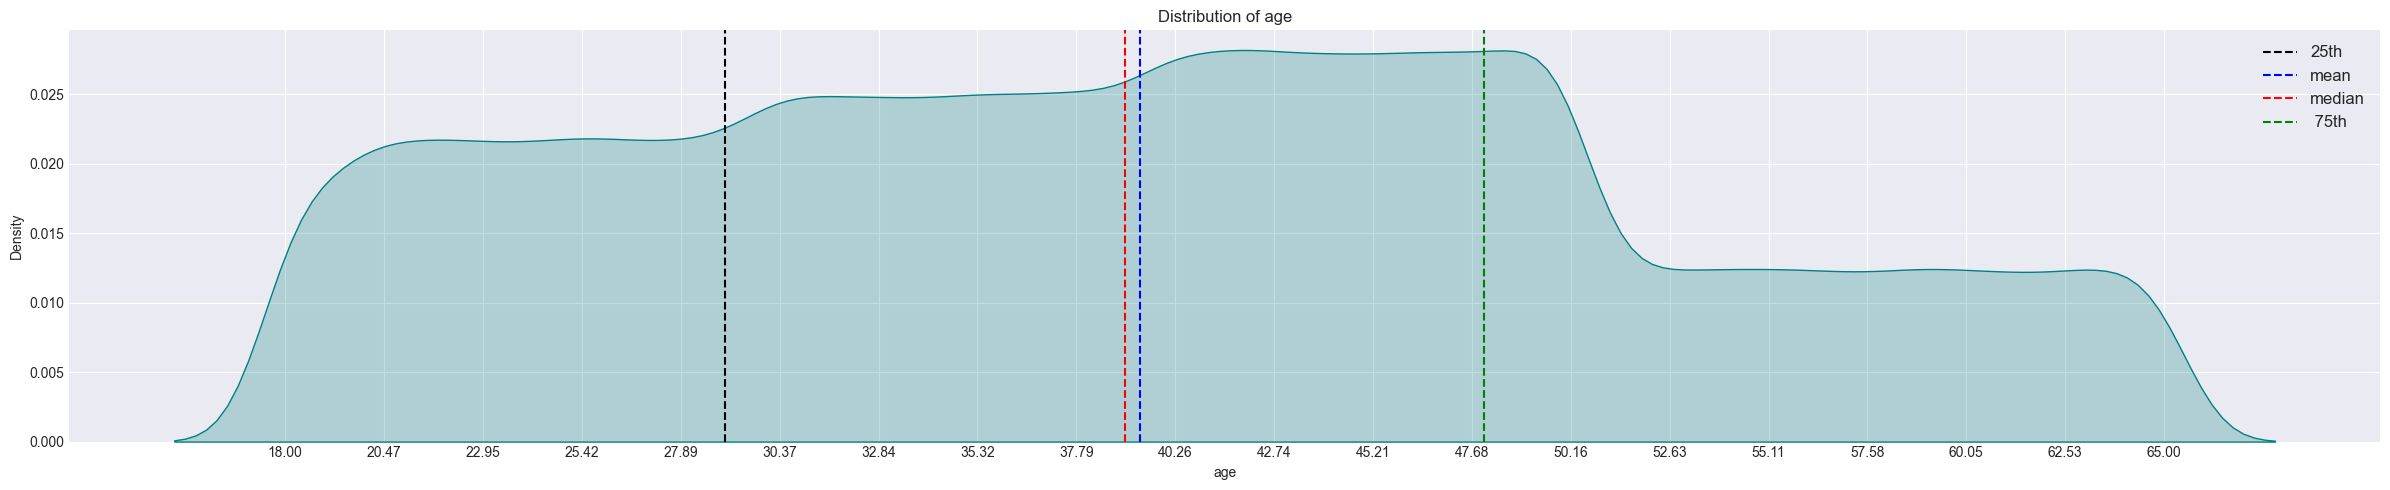

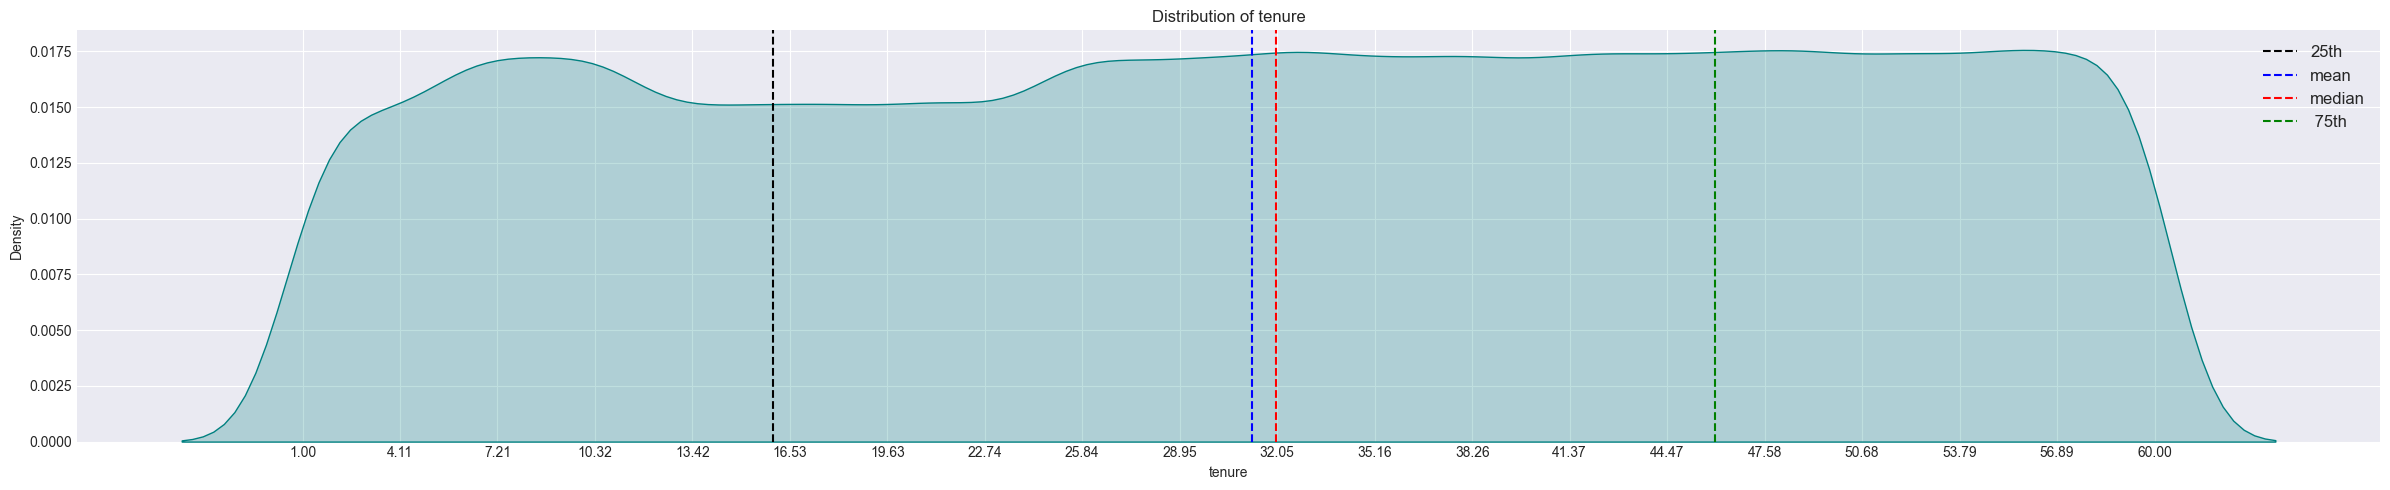

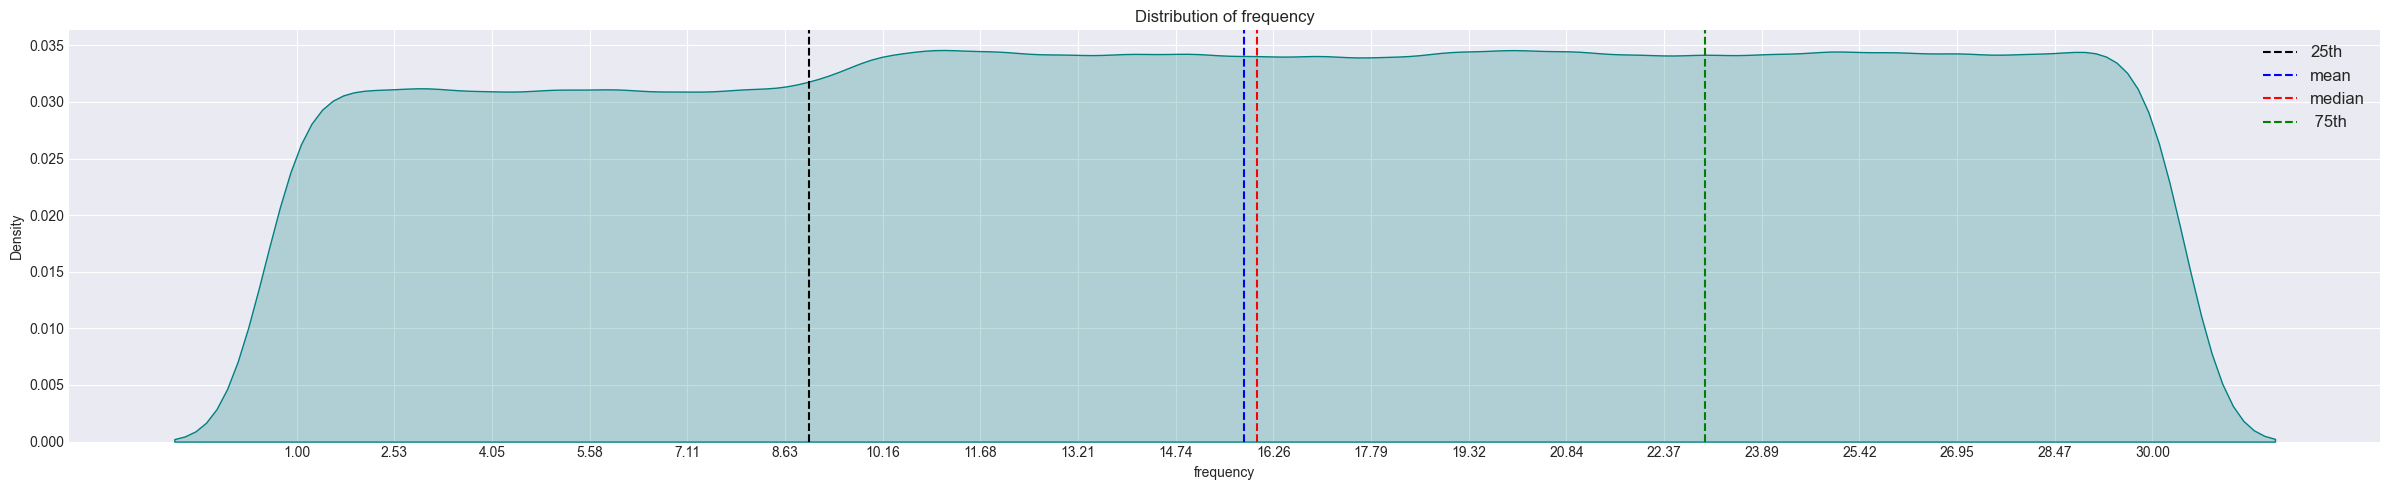

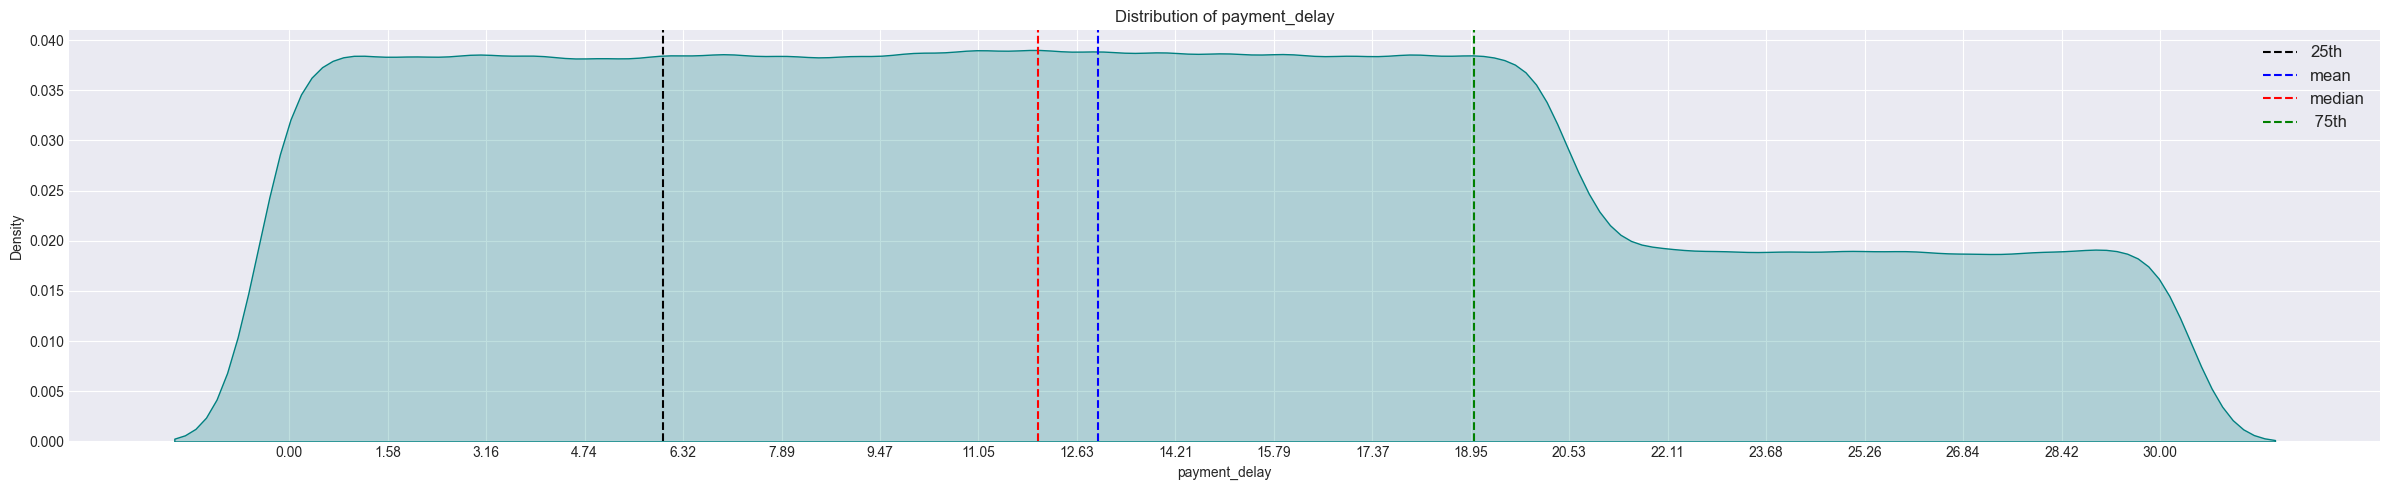

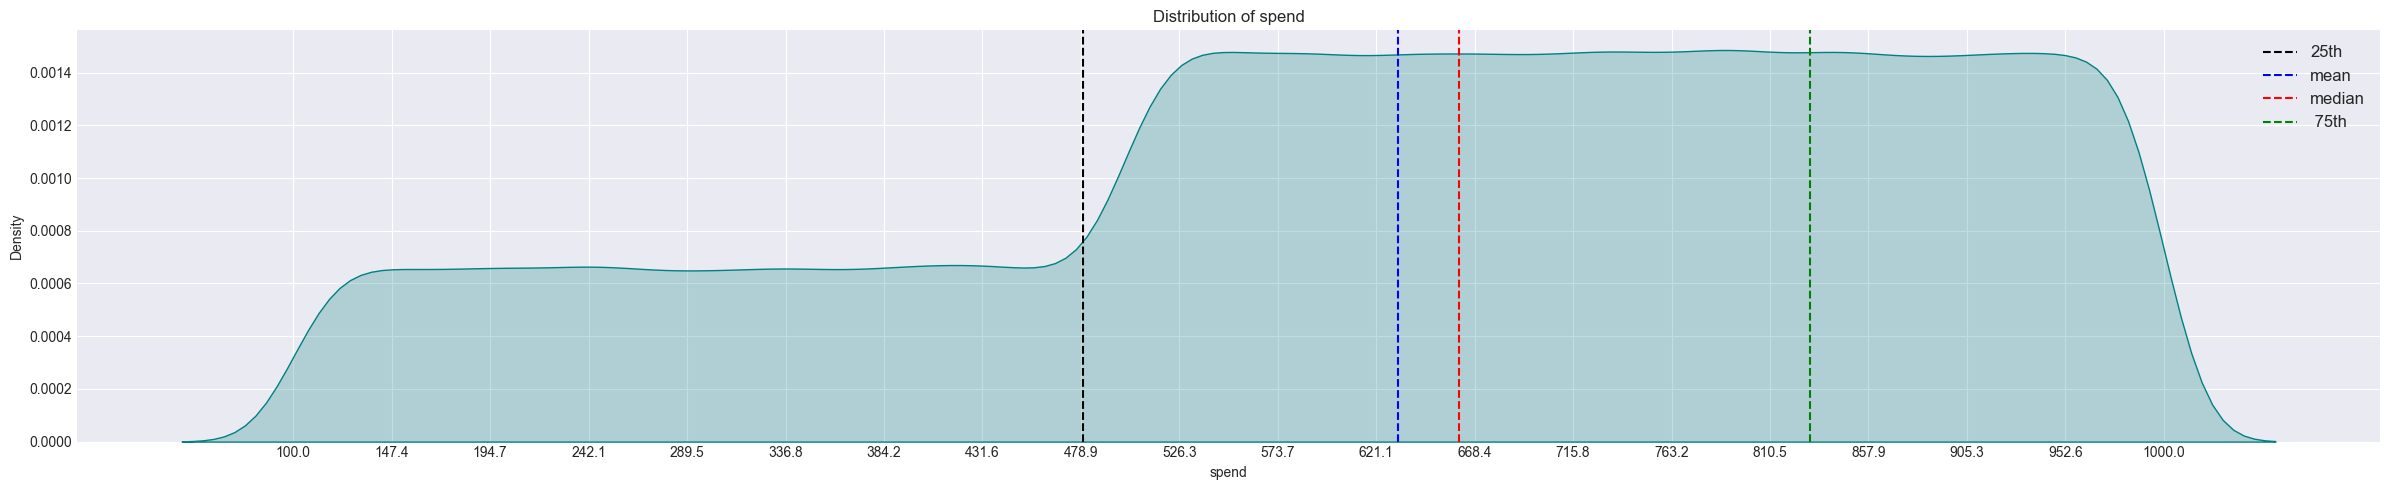

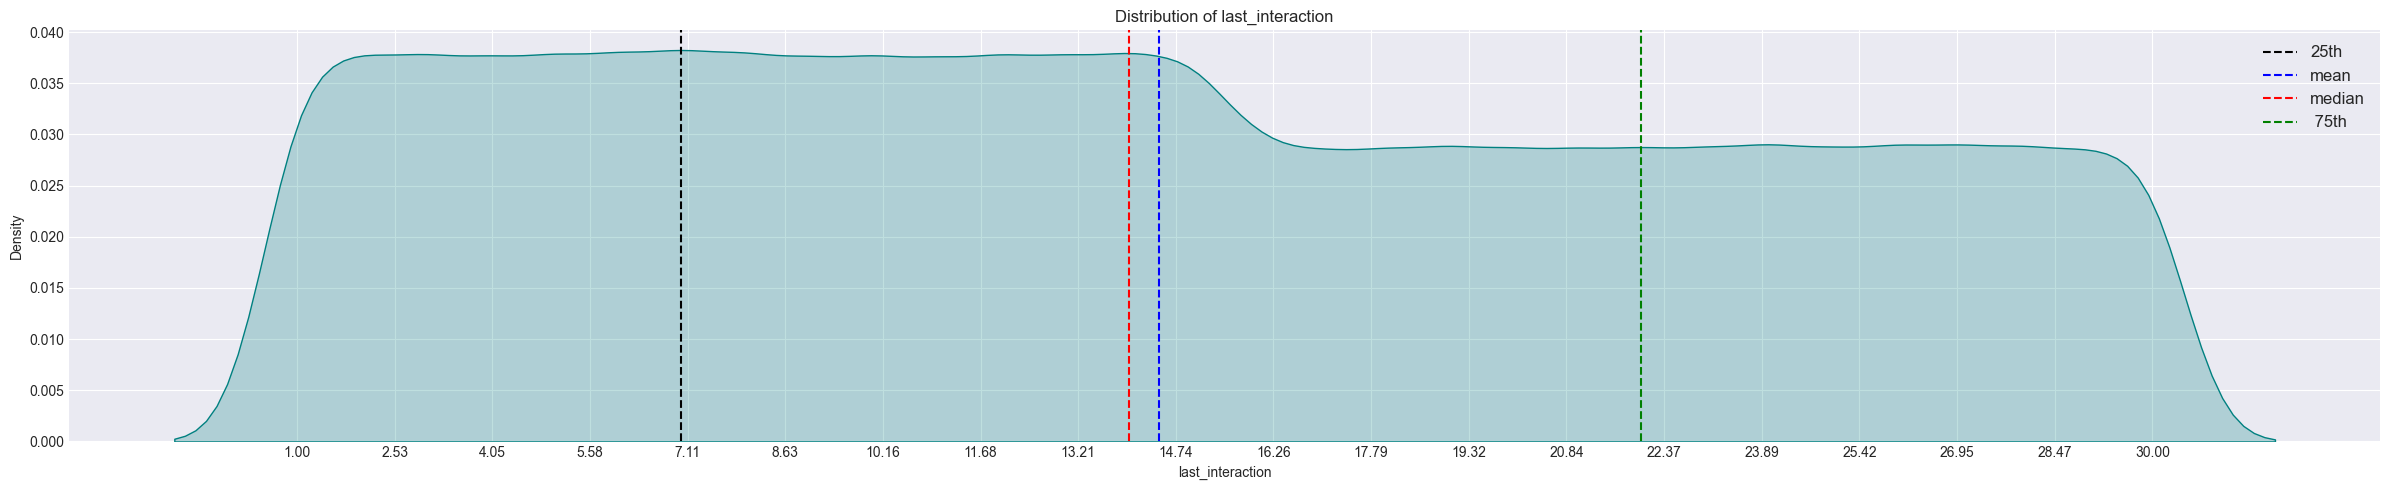

In [7]:
for col in num_values:
    mini = num_values[col].min()
    maxi = num_values[col].max()
    plt.figure(figsize=(24,5))
    sns.kdeplot(x=col,data=num_values,color= 'teal',fill=True)
    plt.axvline(num_values[col].quantile(.25),linestyle ='--',color = 'black',label='25th')
    plt.axvline(num_values[col].mean(),linestyle ='--',color = 'blue',label = 'mean')
    plt.axvline(num_values[col].median(),linestyle ='--',color = 'red',label = 'median')
    plt.axvline(num_values[col].quantile(.75),linestyle ='--',color = 'green',label =' 75th')
    plt.legend(fontsize = 12)
    plt.grid(alpha = 1)
    plt.xticks(np.linspace(mini,maxi,20))
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()
    

In [8]:
query = f'''
    select {",".join(cat_cols)} from data; 
'''
cat_values=sql(query=query)
cat_values.head()

,gender,subscription,calls,contract,churn
0,female,standard,5.0,annual,1.0
1,female,basic,10.0,monthly,1.0
2,female,basic,6.0,quarterly,1.0
3,male,standard,7.0,monthly,1.0
4,male,basic,5.0,monthly,1.0


In [9]:
df ={}
for col in cat_values:
    query = f'''
        select {col},
        count({col}) as count,
        round(100*(count({col})/(select count(*) from data)),2) as percentage
        from data
        group by {col}
    '''
    value_count = sql(query=query)
    df[col]=value_count

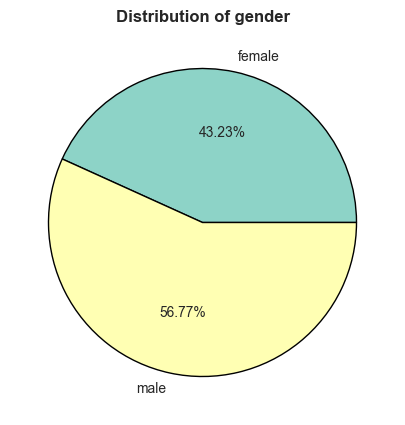

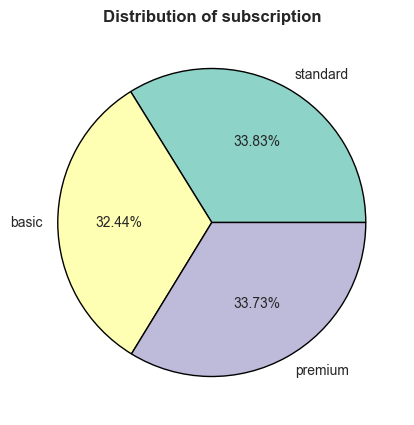

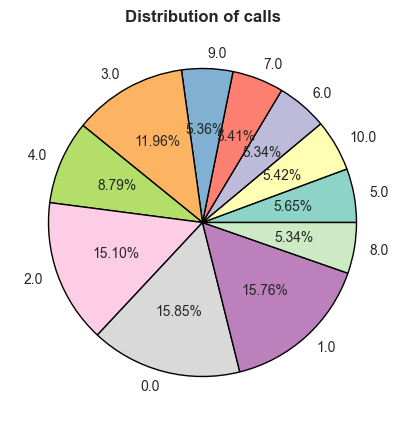

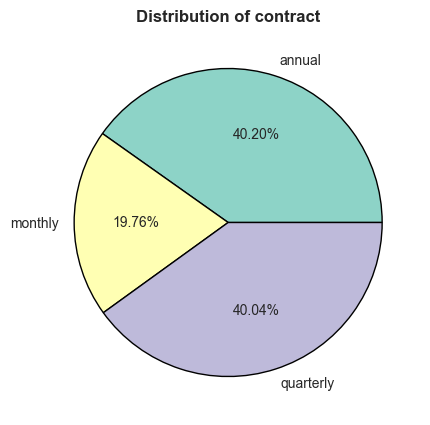

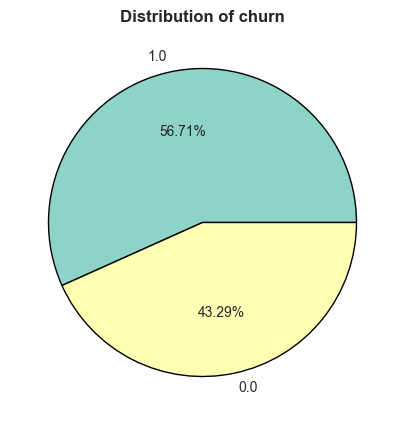

In [10]:
for col in cat_cols:
    dataset = df[col]
    plt.figure(figsize=(10,5))
    plt.pie(dataset['percentage'],labels=df[col].iloc[:,0].tolist(),
            autopct="%.2f%%",colors=plt.cm.Set3.colors,wedgeprops={'edgecolor':'black'})
    plt.title(f'Distribution of {col}',weight= 'bold')
    plt.show()

### Bivariate Analysis with Churn and Category

In [ ]:
cat_cols

['gender', 'subscription', 'calls', 'contract', 'churn']

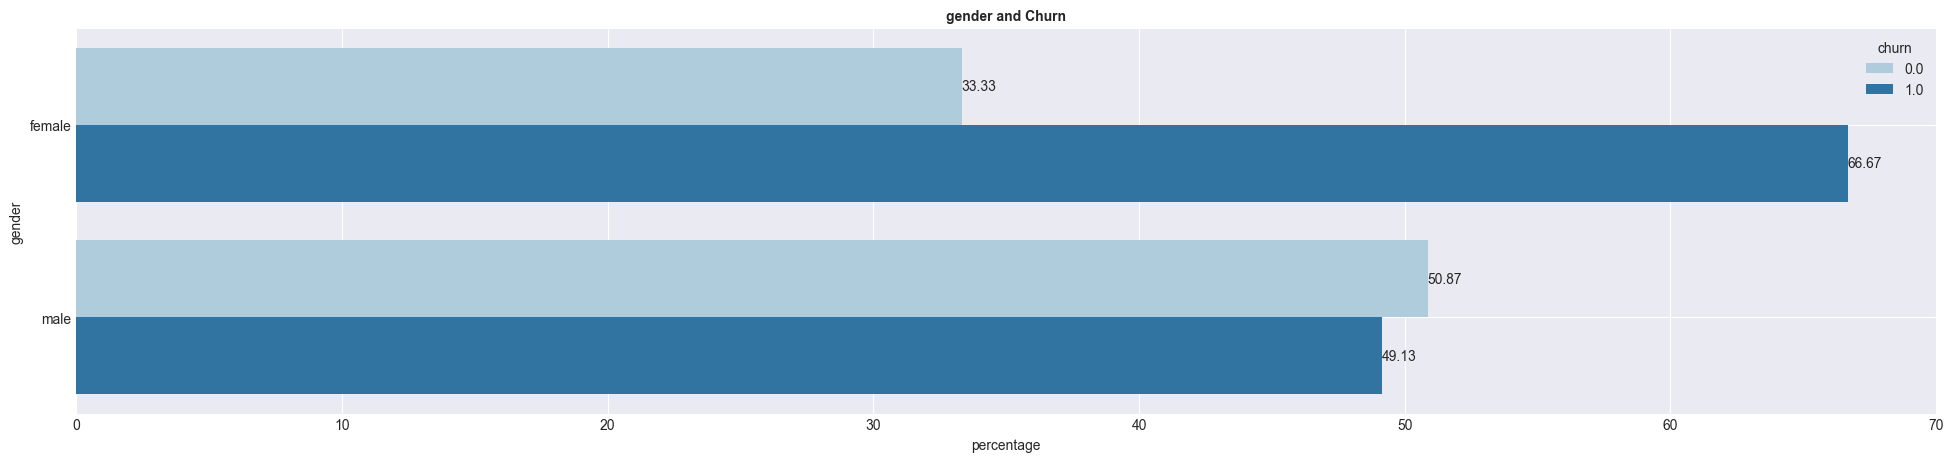

gender ->
__________________________________________________


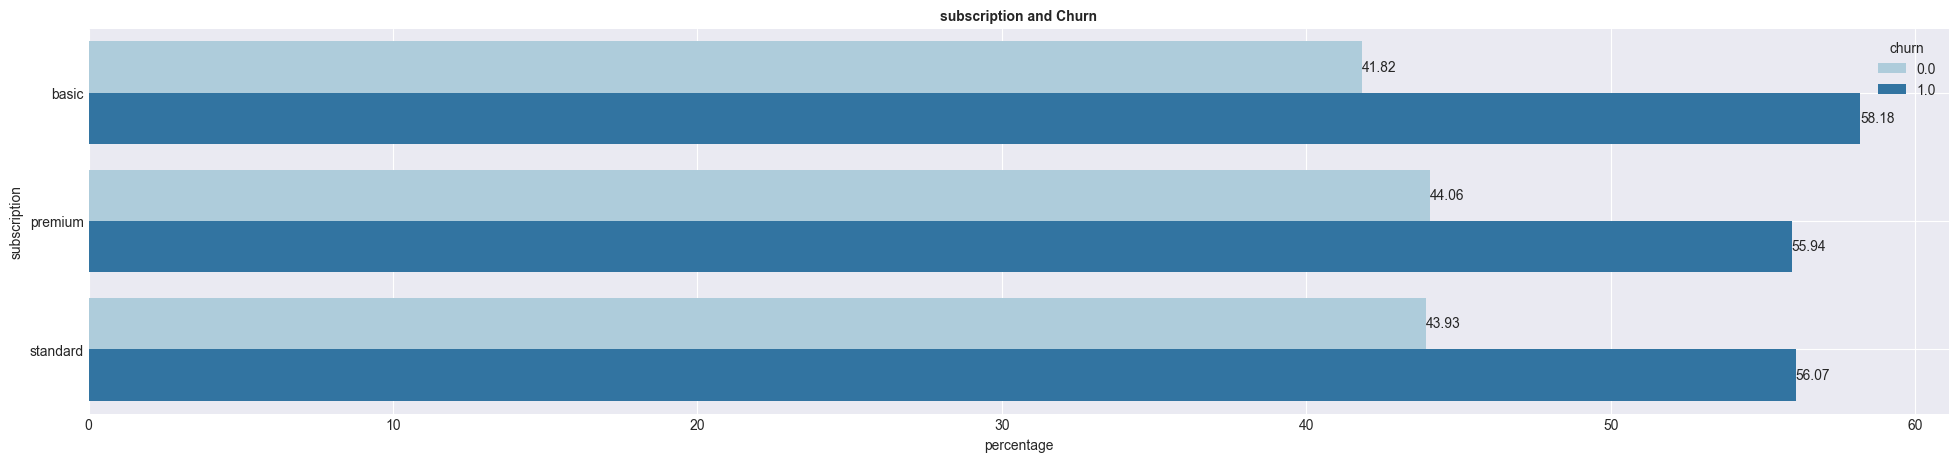

subscription ->
__________________________________________________


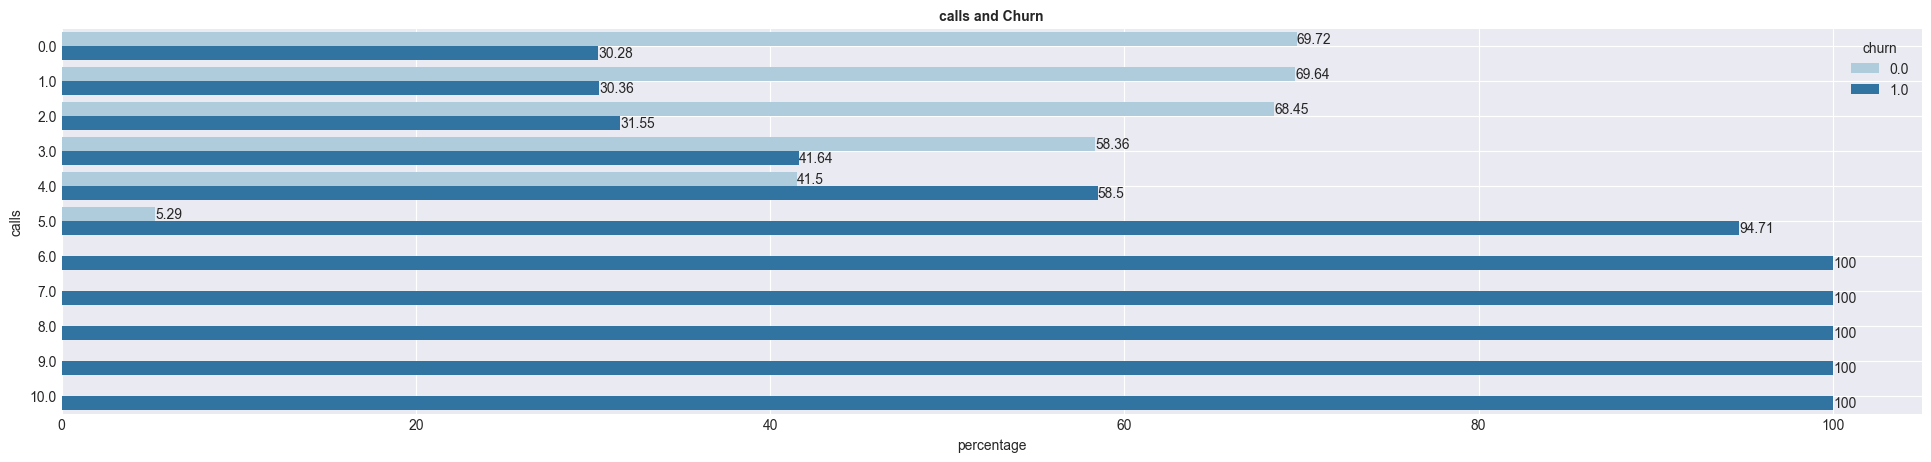

calls ->
__________________________________________________


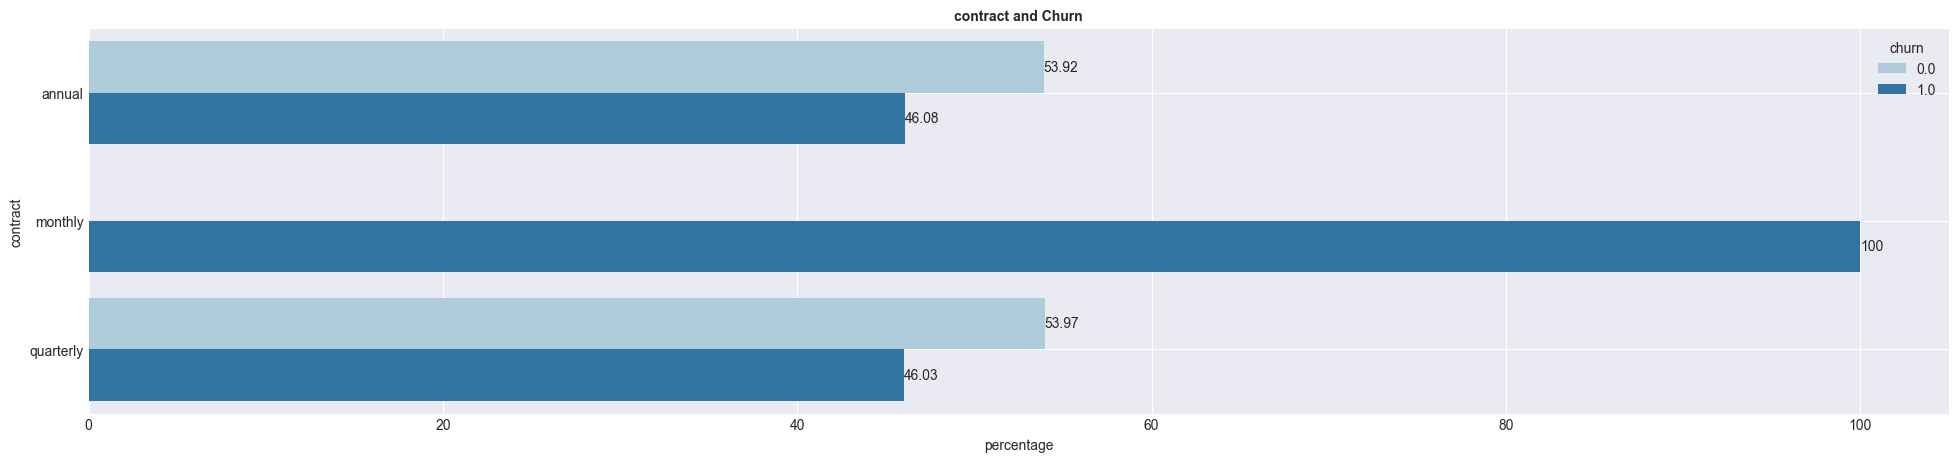

contract ->
__________________________________________________


In [12]:
for col in cat_cols[:-1]:
    query = f'''
            select 
        {col},
        churn,
        round(
            100 * count(*) /
            sum(count(*)) over (partition by {col})
        , 2) as percentage
    from data
    group by {col}, churn
    order by {col}, churn;
        '''
    val = sql(query=query)
    plt.figure(figsize=(24,5))
    ax=sns.barplot(y=col,hue='churn',x='percentage',data=val,palette='Paired',orient='h')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'{col} and Churn',fontsize=10,weight = 'bold')
    plt.grid(alpha = 1)
    plt.show()
    print(f'{col} ->')
    print("_"*50)

### Bivariate Analysis with Churn and Numerical

In [ ]:
num_cols

['age', 'tenure', 'frequency', 'payment_delay', 'spend', 'last_interaction']

In [14]:
df = {}
for col in num_cols:
    query = f'''
        select churn, round(avg({col}),2) as average_{col} from data
        group by churn;
    '''
    val = sql(query=query)
    df[col] = val


In [15]:
for key,value in df.items():
    print(value)
    print("-"*50)

   churn  average_age
0    1.0        41.75
1    0.0        36.26
--------------------------------------------------
   churn  average_tenure
0    1.0           30.47
1    0.0           32.28
--------------------------------------------------
   churn  average_frequency
0    1.0              15.46
1    0.0              16.26
--------------------------------------------------
   churn  average_payment_delay
0    1.0                  15.22
1    0.0                  10.02
--------------------------------------------------
   churn  average_spend
0    1.0         541.29
1    0.0         749.95
--------------------------------------------------
   churn  average_last_interaction
0    1.0                     15.60
1    0.0                     13.01
--------------------------------------------------


### In- Depth Analysis with each column and churn

**Churn VS Age**

In [16]:
query = '''
        select churn,round(avg(age),2) as average_age from data
        group by churn;
    '''
avg_age_churn_category = sql(query=query)

In [ ]:
avg_age_churn_category

,churn,average_age
0,1.0,41.75
1,0.0,36.26


In [18]:
query = '''
    select age from data
    where churn = 0
'''
non_churned_age = sql(query=query)

In [19]:
query = '''
    select age from data
    where churn = 1
'''
churned_age = sql(query=query)

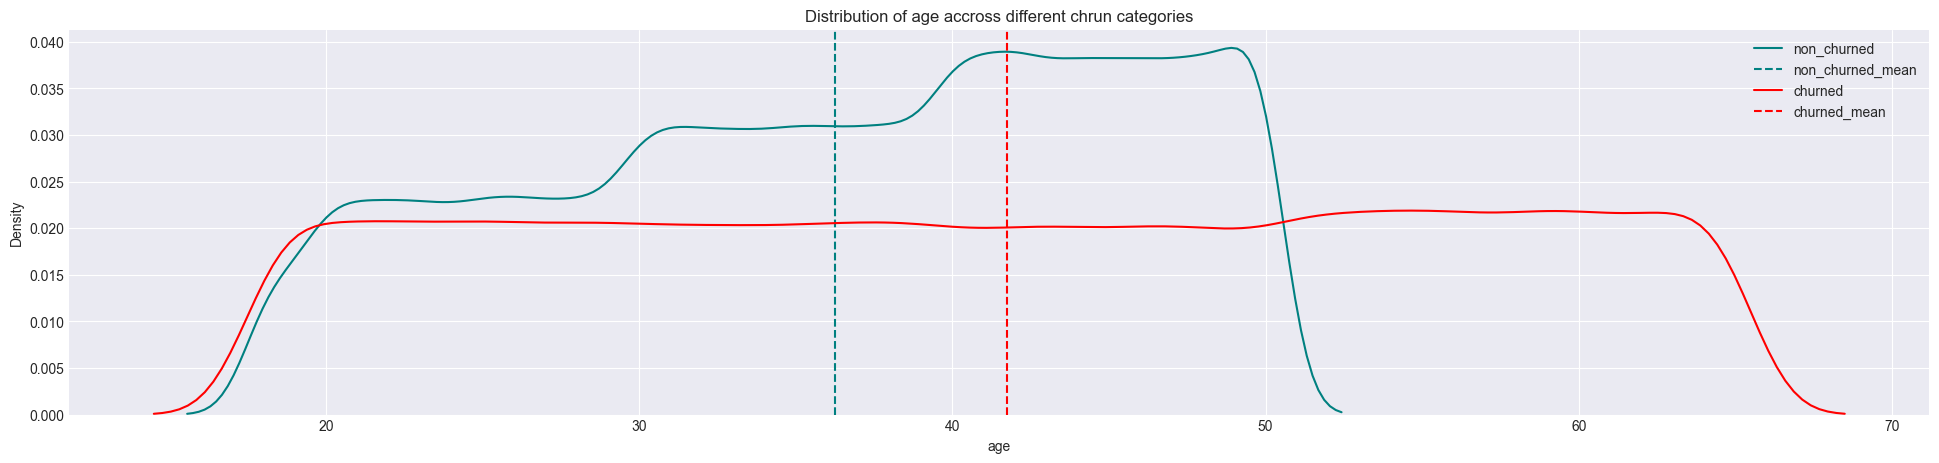

In [20]:
plt.figure(figsize=(24,5))
sns.kdeplot(x='age',data = non_churned_age,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_age),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='age',data = churned_age,color='red',label='churned')
plt.axvline(np.mean(churned_age),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of age accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()

In [21]:
age_stats =churned_age.describe().round(2).reset_index().merge(non_churned_age.describe().round(2).reset_index(),on='index').rename(columns=
    {'age_x':'churned_age_stats','age_y':'non_churned_age_stats'}
)

In [22]:
age_stats

,index,churned_age_stats,non_churned_age_stats
0,count,249999.00,190833.00
1,mean,41.75,36.26
2,std,13.98,9.20
3,min,18.00,18.00
4,25%,30.00,29.00
5,50%,42.00,37.00
6,75%,54.00,44.00
7,max,65.00,50.00


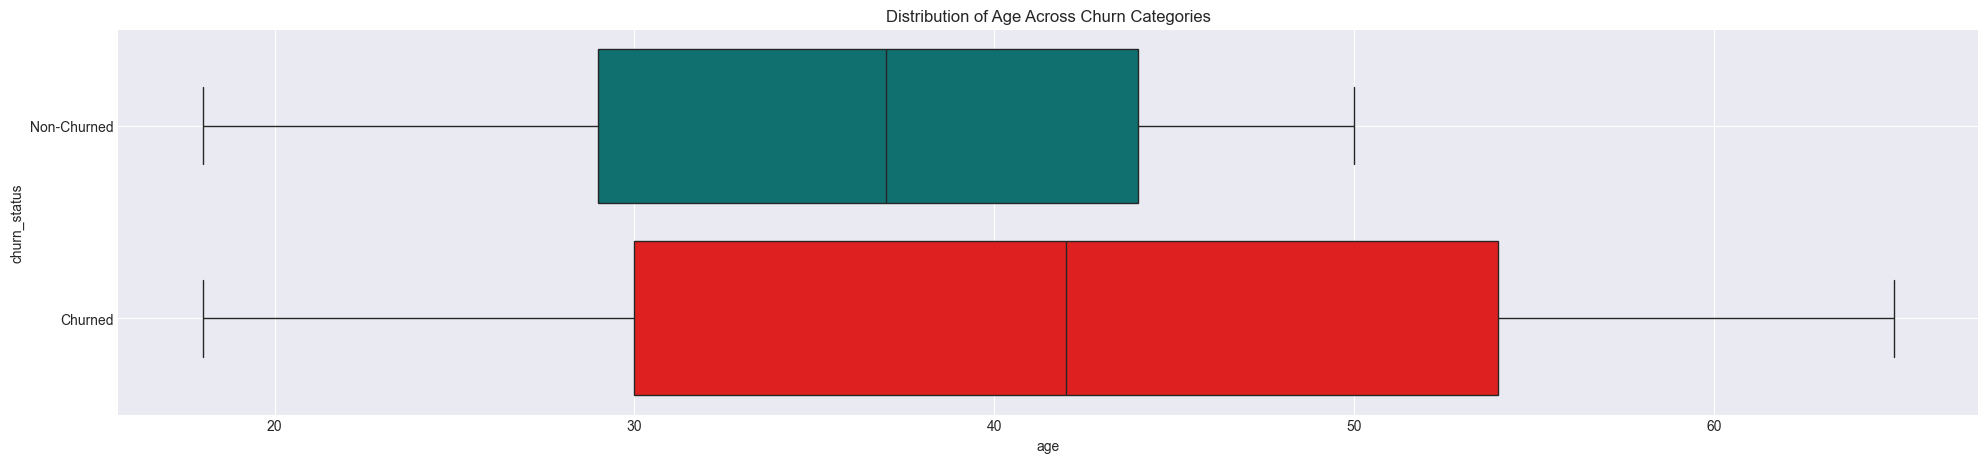

In [23]:
df = pd.DataFrame({
    'age': list(non_churned_age['age']) + list(churned_age['age']),
    'churn_status': ['Non-Churned'] * len(non_churned_age) + ['Churned'] * len(churned_age)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='age', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of Age Across Churn Categories')
plt.legend(fontsize=10)
plt.show()

In [24]:
query = '''
    select tenure from data
    where churn = 0
'''
non_churned_tenure = sql(query=query)
query = '''
    select tenure from data
    where churn = 1
'''
churned_tenure = sql(query=query)

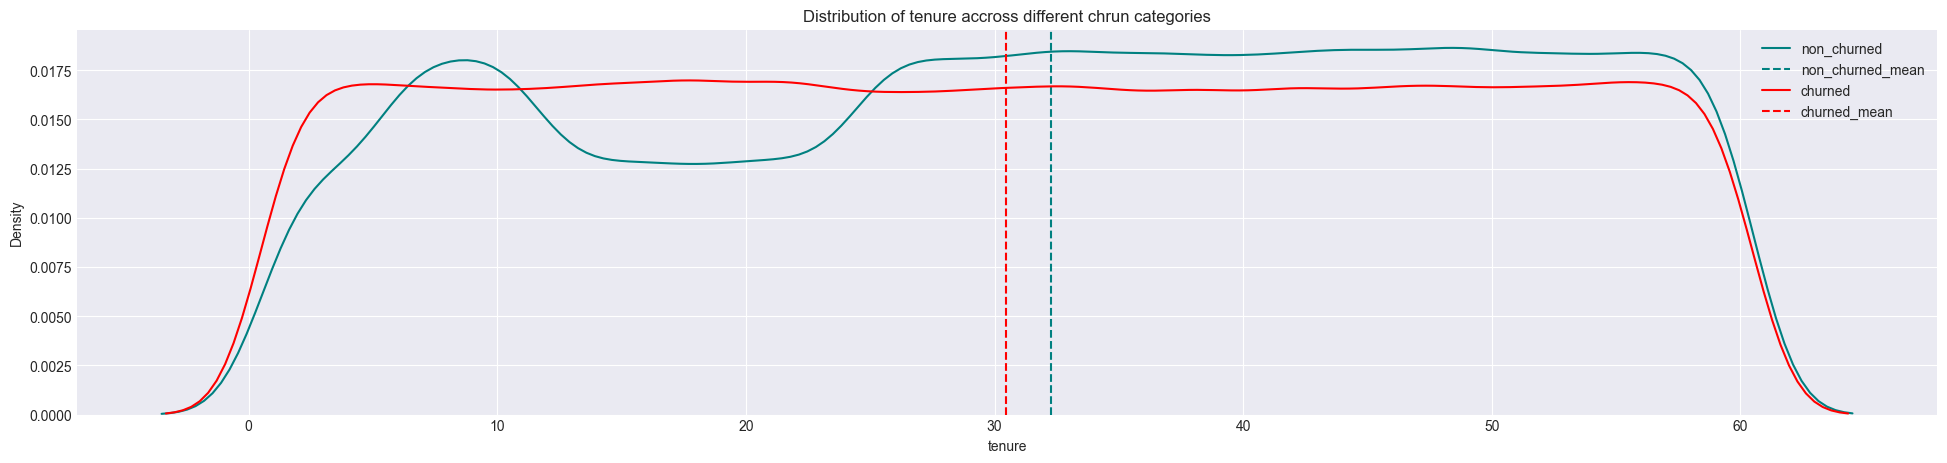

In [25]:
plt.figure(figsize=(24,5))
sns.kdeplot(x='tenure',data = non_churned_tenure,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_tenure),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='tenure',data = churned_tenure,color='red',label='churned')
plt.axvline(np.mean(churned_tenure),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of tenure accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()

In [26]:
tenure_stats =churned_tenure.describe().round(2).reset_index().merge(non_churned_tenure.describe().round(2).reset_index(),on='index').rename(columns=
    {'tenure_x':'churned_tenure_stats','tenure_y':'non_churned_tenure_stats'}
)

In [27]:
tenure_stats

,index,churned_tenure_stats,non_churned_tenure_stats
0,count,249999.00,190833.00
1,mean,30.47,32.28
2,std,17.34,17.09
3,min,1.00,1.00
4,25%,15.00,18.00
5,50%,30.00,33.00
6,75%,46.00,47.00
7,max,60.00,60.00


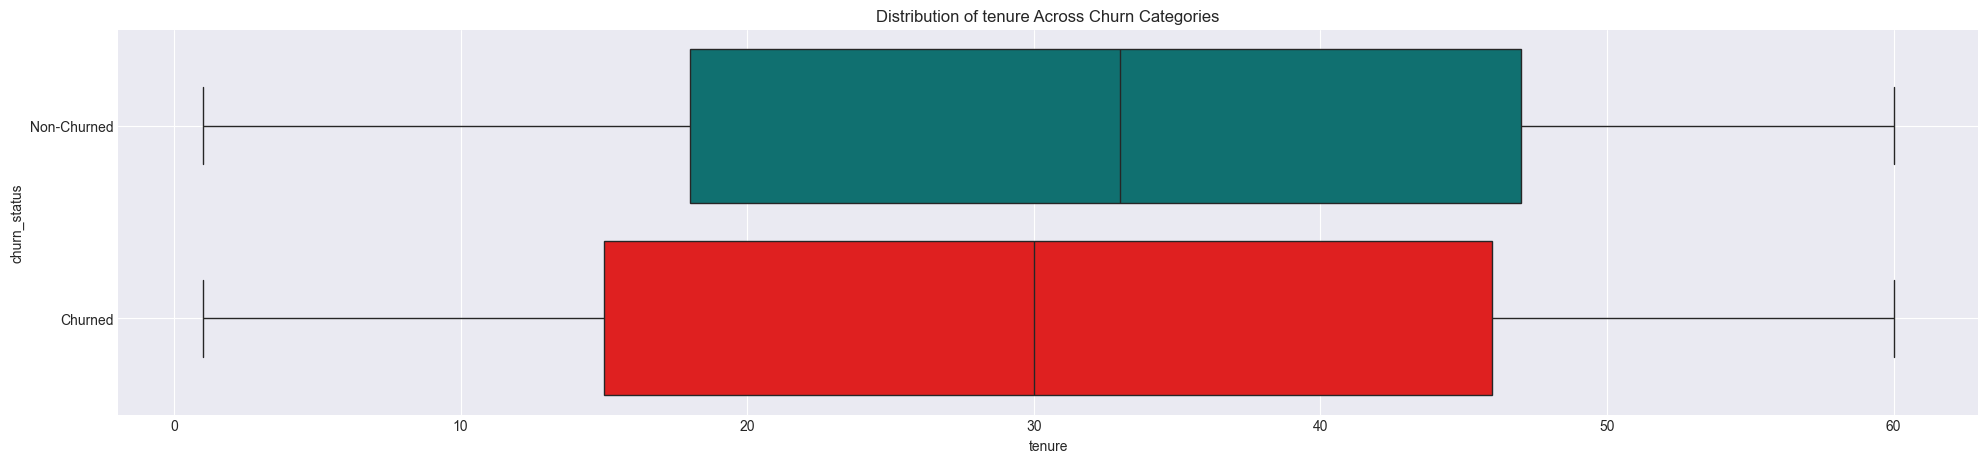

In [28]:
df = pd.DataFrame({
    'tenure': list(non_churned_tenure['tenure']) + list(churned_tenure['tenure']),
    'churn_status': ['Non-Churned'] * len(non_churned_tenure) + ['Churned'] * len(churned_tenure)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='tenure', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of tenure Across Churn Categories')
plt.legend(fontsize=10)
plt.show()

In [29]:
query = '''
    select frequency from data
    where churn = 0
'''
non_churned_frequency = sql(query=query)
query = '''
    select frequency from data
    where churn = 1
'''
churned_frequency = sql(query=query)

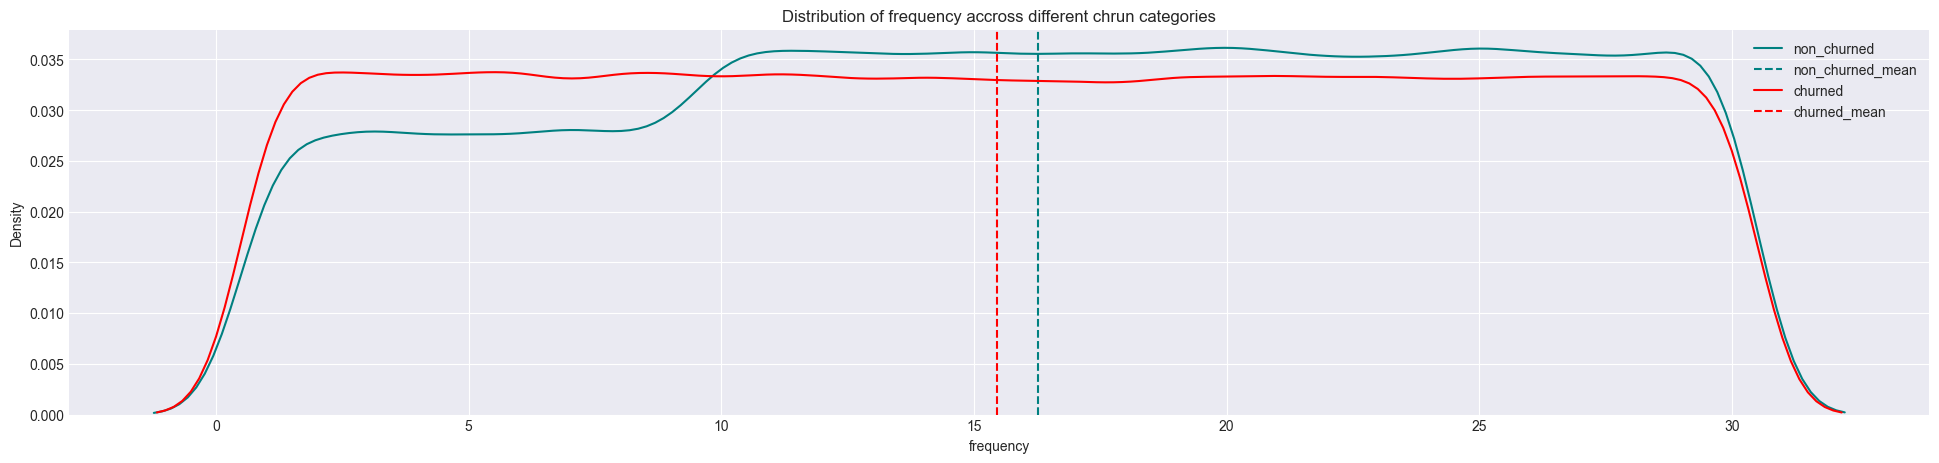

In [30]:
plt.figure(figsize=(24,5))
sns.kdeplot(x='frequency',data = non_churned_frequency,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_frequency),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='frequency',data = churned_frequency,color='red',label='churned')
plt.axvline(np.mean(churned_frequency),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of frequency accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()

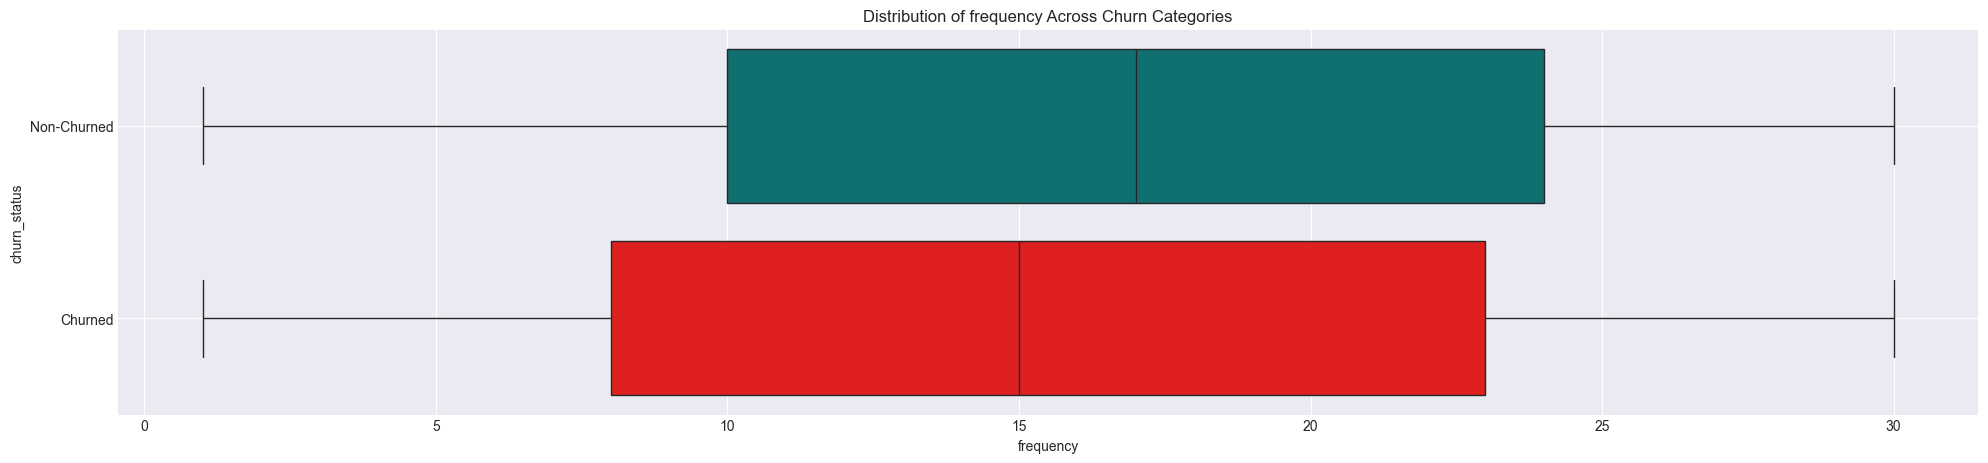

In [31]:
df = pd.DataFrame({
    'frequency': list(non_churned_frequency['frequency']) + list(churned_frequency['frequency']),
    'churn_status': ['Non-Churned'] * len(non_churned_frequency) + ['Churned'] * len(churned_frequency)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='frequency', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of frequency Across Churn Categories')
plt.legend(fontsize=10)
plt.show()

In [32]:
frequency_stats =churned_frequency.describe().round(2).reset_index().merge(non_churned_frequency.describe().round(2).reset_index(),on='index').rename(columns=
    {'frequency_x':'churned_frequency_stats','frequency_y':'non_churned_frequency_stats'}
)

In [33]:
frequency_stats

,index,churned_frequency_stats,non_churned_frequency_stats
0,count,249999.00,190833.00
1,mean,15.46,16.26
2,std,8.68,8.45
3,min,1.00,1.00
4,25%,8.00,10.00
5,50%,15.00,17.00
6,75%,23.00,24.00
7,max,30.00,30.00


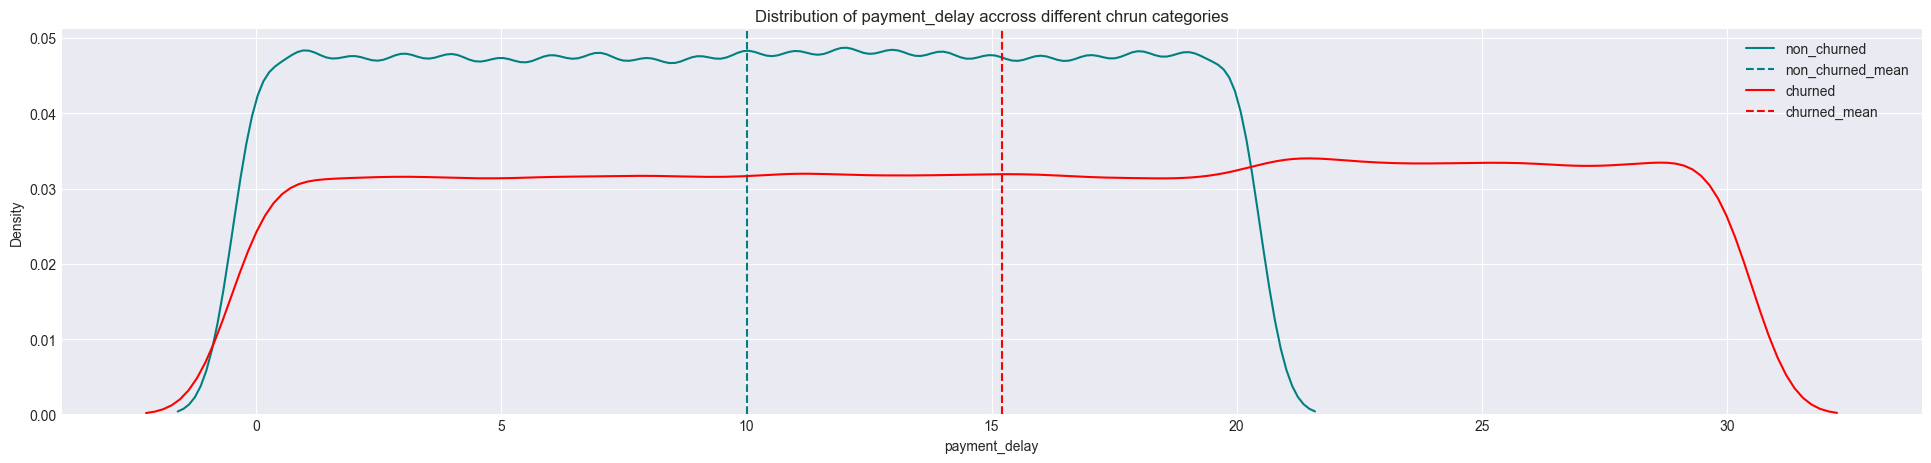

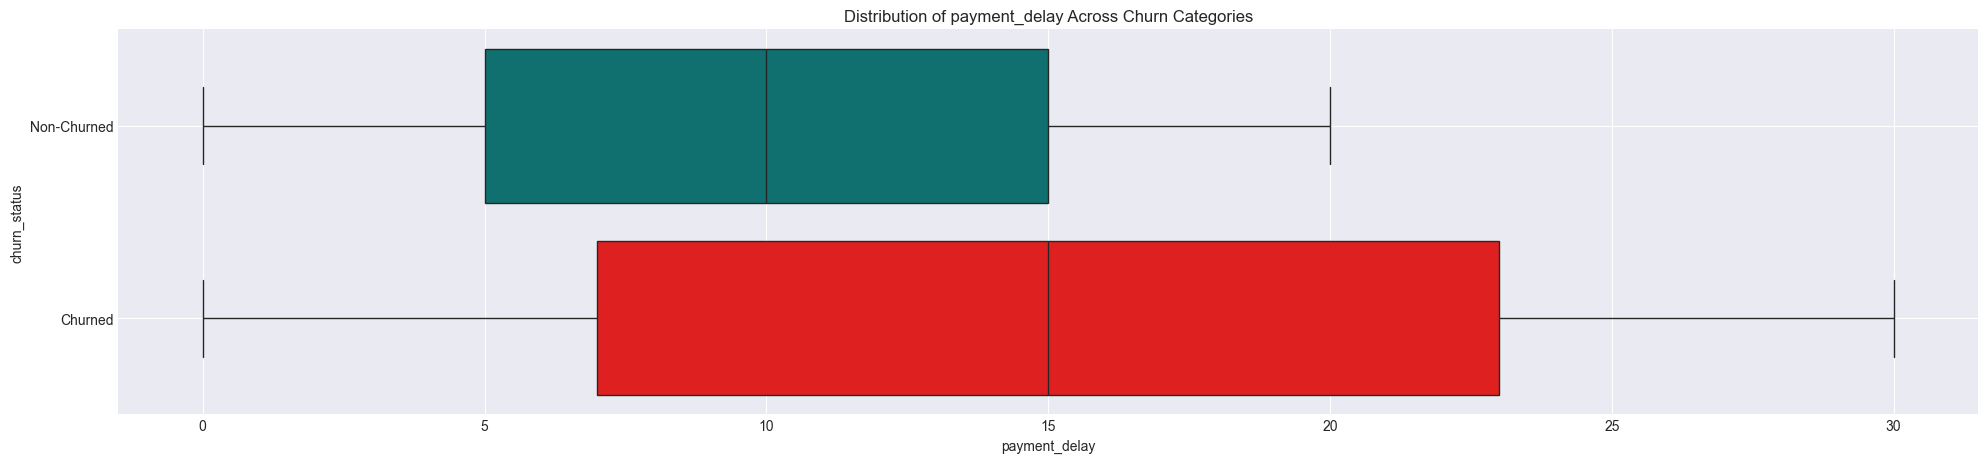

,index,churned_payment_delay_stats,non_churned_payment_delay_stats
0,count,249999.00,190833.00
1,mean,15.22,10.02
2,std,8.97,6.06
3,min,0.00,0.00
4,25%,7.00,5.00
5,50%,15.00,10.00
6,75%,23.00,15.00
7,max,30.00,20.00


In [34]:
query = '''
    select payment_delay from data
    where churn = 0
'''
non_churned_payment_delay = sql(query=query)
query = '''
    select payment_delay from data
    where churn = 1
'''
churned_payment_delay = sql(query=query)
plt.figure(figsize=(24,5))
sns.kdeplot(x='payment_delay',data = non_churned_payment_delay,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_payment_delay),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='payment_delay',data = churned_payment_delay,color='red',label='churned')
plt.axvline(np.mean(churned_payment_delay),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of payment_delay accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()
df = pd.DataFrame({
    'payment_delay': list(non_churned_payment_delay['payment_delay']) + list(churned_payment_delay['payment_delay']),
    'churn_status': ['Non-Churned'] * len(non_churned_payment_delay) + ['Churned'] * len(churned_payment_delay)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='payment_delay', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of payment_delay Across Churn Categories')
plt.legend(fontsize=10)
plt.show()
payment_delay_stats =churned_payment_delay.describe().round(2).reset_index().merge(non_churned_payment_delay.describe().round(2).reset_index(),on='index').rename(columns=
    {'payment_delay_x':'churned_payment_delay_stats','payment_delay_y':'non_churned_payment_delay_stats'}
)
payment_delay_stats

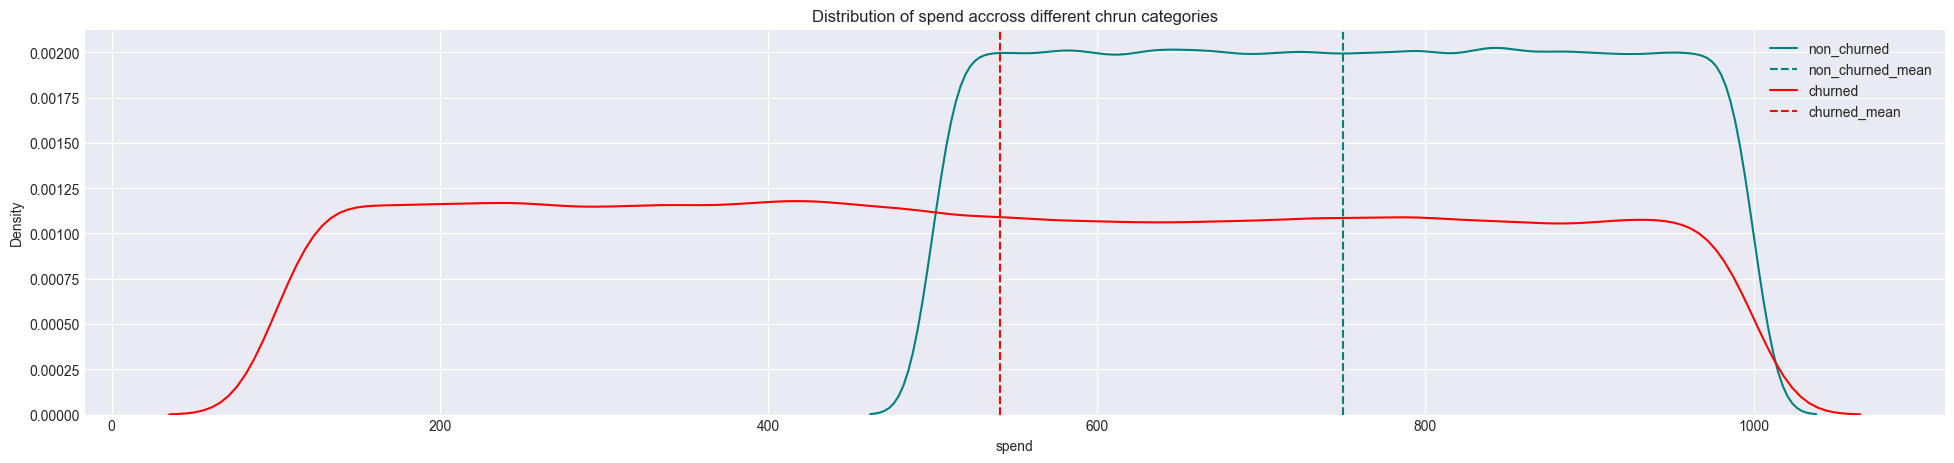

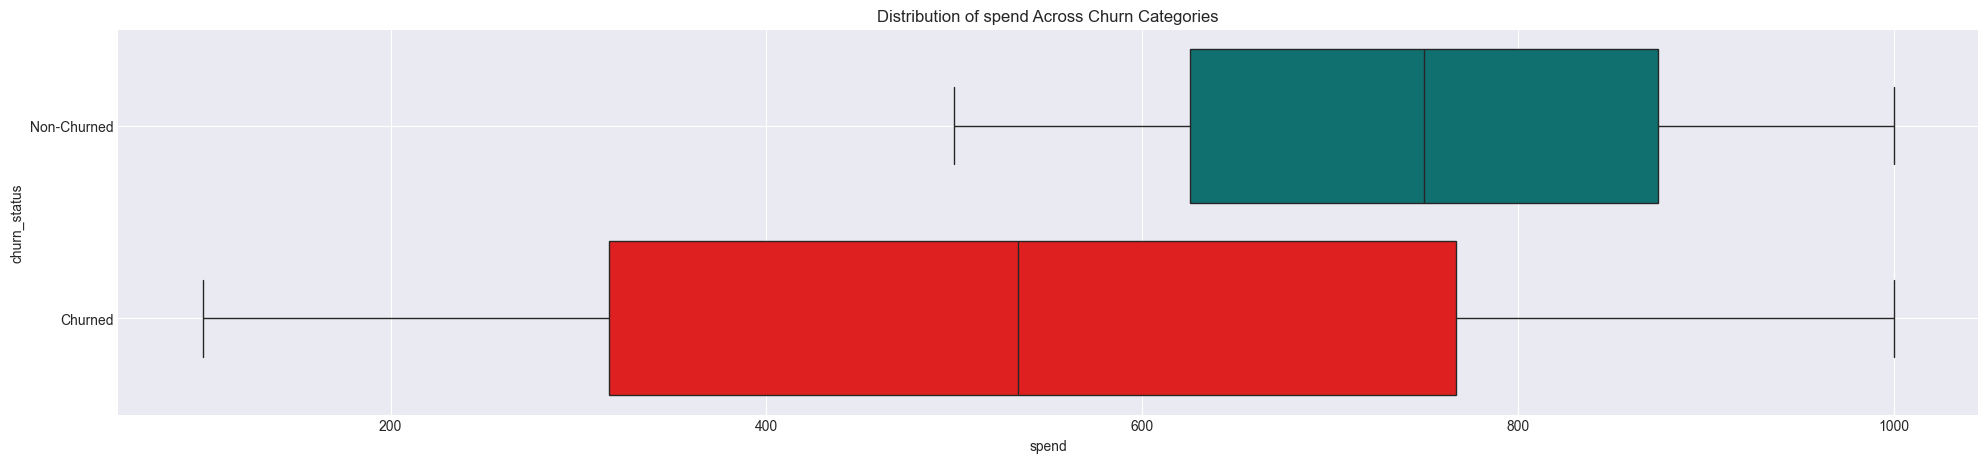

,index,churned_spend_stats,non_churned_spend_stats
0,count,249999.00,190833.00
1,mean,541.29,749.95
2,std,259.85,144.22
3,min,100.00,500.00
4,25%,316.00,625.30
5,50%,534.00,749.98
6,75%,767.00,874.74
7,max,1000.00,1000.00


In [35]:
query = '''
    select spend from data
    where churn = 0
'''
non_churned_spend = sql(query=query)
query = '''
    select spend from data
    where churn = 1
'''
churned_spend = sql(query=query)
plt.figure(figsize=(24,5))
sns.kdeplot(x='spend',data = non_churned_spend,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_spend),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='spend',data = churned_spend,color='red',label='churned')
plt.axvline(np.mean(churned_spend),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of spend accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()
df = pd.DataFrame({
    'spend': list(non_churned_spend['spend']) + list(churned_spend['spend']),
    'churn_status': ['Non-Churned'] * len(non_churned_spend) + ['Churned'] * len(churned_spend)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='spend', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of spend Across Churn Categories')
plt.legend(fontsize=10)
plt.show()
spend_stats =churned_spend.describe().round(2).reset_index().merge(non_churned_spend.describe().round(2).reset_index(),on='index').rename(columns=
    {'spend_x':'churned_spend_stats','spend_y':'non_churned_spend_stats'}
)
spend_stats

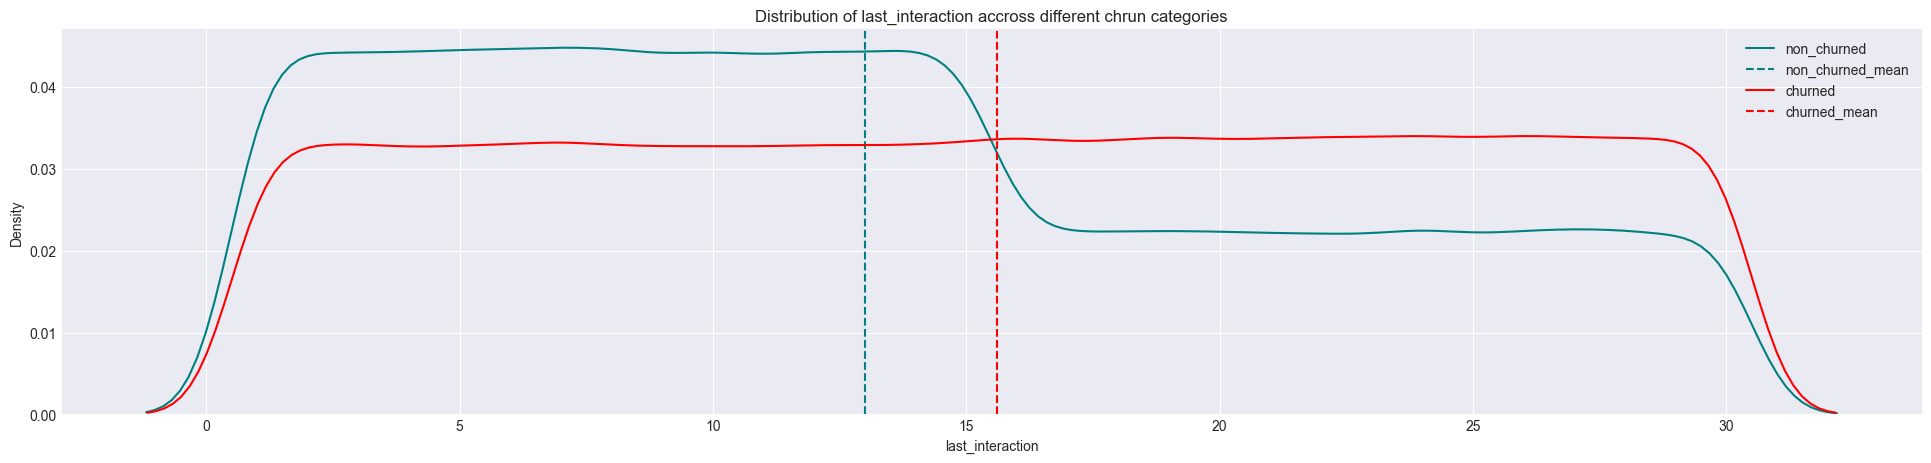

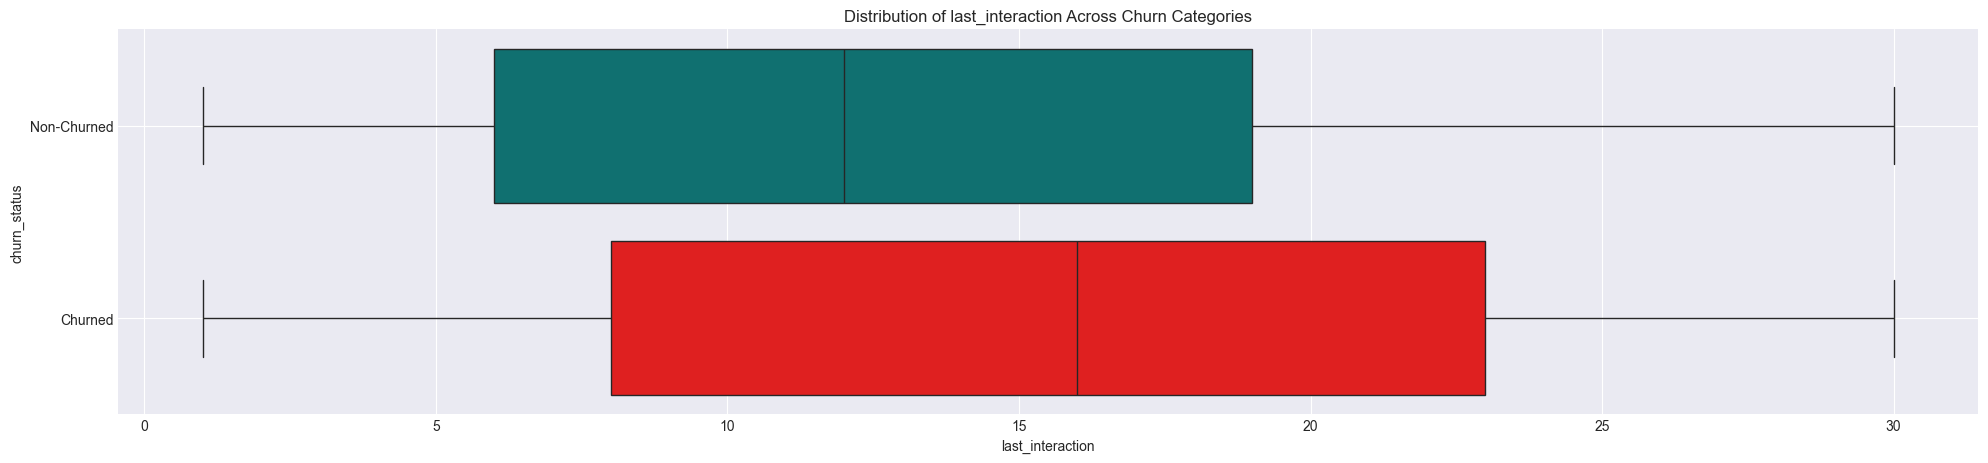

,index,churned_last_interaction_stats,non_churned_last_interaction_stats
0,count,249999.00,190833.00
1,mean,15.60,13.01
2,std,8.65,8.29
3,min,1.00,1.00
4,25%,8.00,6.00
5,50%,16.00,12.00
6,75%,23.00,19.00
7,max,30.00,30.00


In [36]:
query = '''
    select last_interaction from data
    where churn = 0
'''
non_churned_last_interaction = sql(query=query)
query = '''
    select last_interaction from data
    where churn = 1
'''
churned_last_interaction = sql(query=query)
plt.figure(figsize=(24,5))
sns.kdeplot(x='last_interaction',data = non_churned_last_interaction,color='teal',label='non_churned')
plt.axvline(np.mean(non_churned_last_interaction),linestyle = '--',color = 'teal',label = 'non_churned_mean')
sns.kdeplot(x='last_interaction',data = churned_last_interaction,color='red',label='churned')
plt.axvline(np.mean(churned_last_interaction),linestyle = '--',color = 'red',label ='churned_mean')
plt.grid(alpha = 1)
plt.title('Distribution of last_interaction accross different chrun categories')
plt.legend(fontsize = 10)
plt.show()
df = pd.DataFrame({
    'last_interaction': list(non_churned_last_interaction['last_interaction']) + list(churned_last_interaction['last_interaction']),
    'churn_status': ['Non-Churned'] * len(non_churned_last_interaction) + ['Churned'] * len(churned_last_interaction)
})
plt.figure(figsize=(24,5))
sns.boxplot(y='churn_status', x='last_interaction', data=df, palette=['teal','red'])
plt.grid(alpha=1)
plt.title('Distribution of last_interaction Across Churn Categories')
plt.legend(fontsize=10)
plt.show()
last_interaction_stats =churned_last_interaction.describe().round(2).reset_index().merge(non_churned_last_interaction.describe().round(2).reset_index(),on='index').rename(columns=
    {'last_interaction_x':'churned_last_interaction_stats','last_interaction_y':'non_churned_last_interaction_stats'}
)
last_interaction_stats

### Multivariate Analysis with churn column

In [55]:
query = '''select age from data
        where churn = 1 and gender = 'male';
        '''
churned_male_age = sql(query=query)
query = '''select age from data
        where churn = 0 and gender = 'male';
        '''
non_churned_male_age = sql(query=query)

query = '''select age from data
        where churn = 1 and gender = 'female';
        '''
churned_female_age = sql(query=query)
query = '''select age from data
        where churn = 0 and gender = 'female';
        '''
non_churned_female_age = sql(query=query)


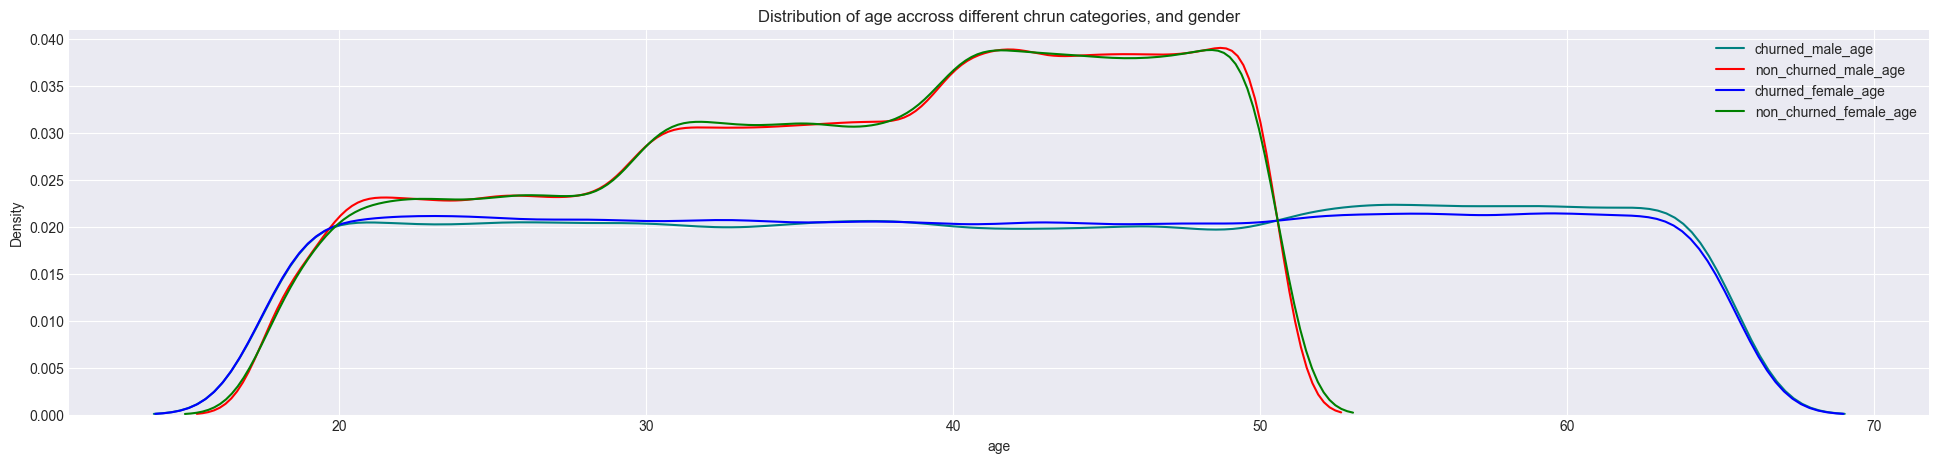

In [56]:
plt.figure(figsize=(24,5))
sns.kdeplot(x='age',data = churned_male_age,color='teal',label='churned_male_age')
sns.kdeplot(x='age',data = non_churned_male_age,color='red',label='non_churned_male_age')
sns.kdeplot(x='age',data = churned_female_age,color='blue',label='churned_female_age')
sns.kdeplot(x='age',data = non_churned_female_age,color='green',label='non_churned_female_age')
plt.grid(alpha = 1)
plt.title('Distribution of age accross different chrun categories, and gender')
plt.legend(fontsize = 10)
plt.show()